# Skillset Cluster Analysis

The goal in this investigation is to create a dendrogram (for a weight class) to  see if we can observe clustering based on skillset.
That is, can we identify those fighters with wrestling, BJJ, Striking backgrounds by applying techniques from machine learning?

In [1]:
# First, run main.py to scrape the necessary data
# It may take a while if this is your first scrape.
# After your initial scrape, the script will update your database with the latest fights
# The script will print the current event being scraped.
# !python3 main.py

def height_to_inches(h):
    if h == '--':
        height = 0
    else:
        h_list = h.split()
        height = int(h_list[0].strip('\''))*12 + int(h_list[1].strip('\"'))
    return height


In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from os import getcwd, makedirs
from os.path import join, exists
from datetime import date
from scipy.cluster.hierarchy import dendrogram, linkage

figure_dir = join(getcwd(),'Figures')
if not exists(figure_dir):
    makedirs(figure_dir)

processed_events_dir = getcwd() + '/UFCStats_Dicts/Processed/'
filename = 'All_Fighters.csv'
df = pd.read_csv(join(processed_events_dir,filename),parse_dates=['LastFightDate','NextFightDate','DOB'])

df = df.drop(df.index[pd.isna(df['LastFightDate'])])
df = df.drop(df.index[df.UFCFights < 2])
df['stance'] = df['stance'].astype('category')
df['height'] = df['height'].apply(height_to_inches)
df['weight'] = pd.to_numeric(df['weight'], errors='coerce')
df['reach'] = pd.to_numeric(df['reach'], errors='coerce')
df['WinRatio'] = df['W']/df['TotalFights']


sns.set()

SMALL_SIZE = 20
MEDIUM_SIZE = 30
BIGGER_SIZE = 40
TITLE_FONT_SIZE = 35

params = {'font.size': MEDIUM_SIZE,
          'legend.fontsize': MEDIUM_SIZE,
          'legend.title_fontsize': MEDIUM_SIZE,
          'figure.figsize': (16, 9),
          'axes.labelsize': MEDIUM_SIZE,
          'axes.titlesize': TITLE_FONT_SIZE,
          'xtick.labelsize': SMALL_SIZE,
          'ytick.labelsize': SMALL_SIZE}
plt.rcParams.update(params)

dpi_save = 200

The UFC is an evolving sport, so let's focus on the modern era. However, there isn't really a well-defined "modern era". The first UFC fight to air on a major network was Cain Velasquez vs. Junior Dos Santos, which was aired live on FOX on Nov. 11, 2011. So let's limit our investigation to 2012-2020. (At the time of composing this document, the last event occured on Nov. 7, 2020.)

We need to curate the data to make the comparison fair.
The first fight of the card is always 3 rounds, so we need to remove 5-round fights.
Also, catch weight is not actually a weight class, so let's remove it.

In [24]:
# df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2168 entries, 0 to 3579
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   FighterName    2168 non-null   object        
 1   FighterLink    2168 non-null   object        
 2   LastFightDate  2168 non-null   datetime64[ns]
 3   NextFightDate  57 non-null     datetime64[ns]
 4   W              2168 non-null   int64         
 5   L              2168 non-null   int64         
 6   D              2168 non-null   int64         
 7   NC             2168 non-null   int64         
 8   TotalFights    2168 non-null   int64         
 9   UFCFights      2168 non-null   int64         
 10  height         2168 non-null   int64         
 11  weight         2160 non-null   float64       
 12  reach          1443 non-null   float64       
 13  stance         2057 non-null   category      
 14  DOB            2168 non-null   object        
 15  SLpM           2168 n

In [31]:
df_modern = df[df.LastFightDate >= pd.Timestamp(2019,11,22)].copy()
# df_modern = df_modern[(df_modern.weight > 156) & (df_modern.weight<=171)]
# df_modern = df_modern[(df_modern.weight > 206)]
# df_modern = df_modern[(df_modern.weight > 136) & (df_modern.weight<=146)]
df_modern = df_modern[(df_modern.weight > 186) & (df_modern.weight<=206)]
# Z = linkage(df_modern[['TotalFights','UFCFights','SLpM','StrAcc','SApM','StrDef','TDAvg','TDAcc','TDDef','SubAvg']], 'ward')
# Z = linkage(df_modern[['SLpM','StrAcc','SApM','StrDef','TDAvg','TDAcc','TDDef','SubAvg']], 'ward')
Z = linkage(df_modern[['TotalFights','UFCFights','WinRatio','SLpM','SApM','TDAvg','TDDef','SubAvg']], 'centroid')

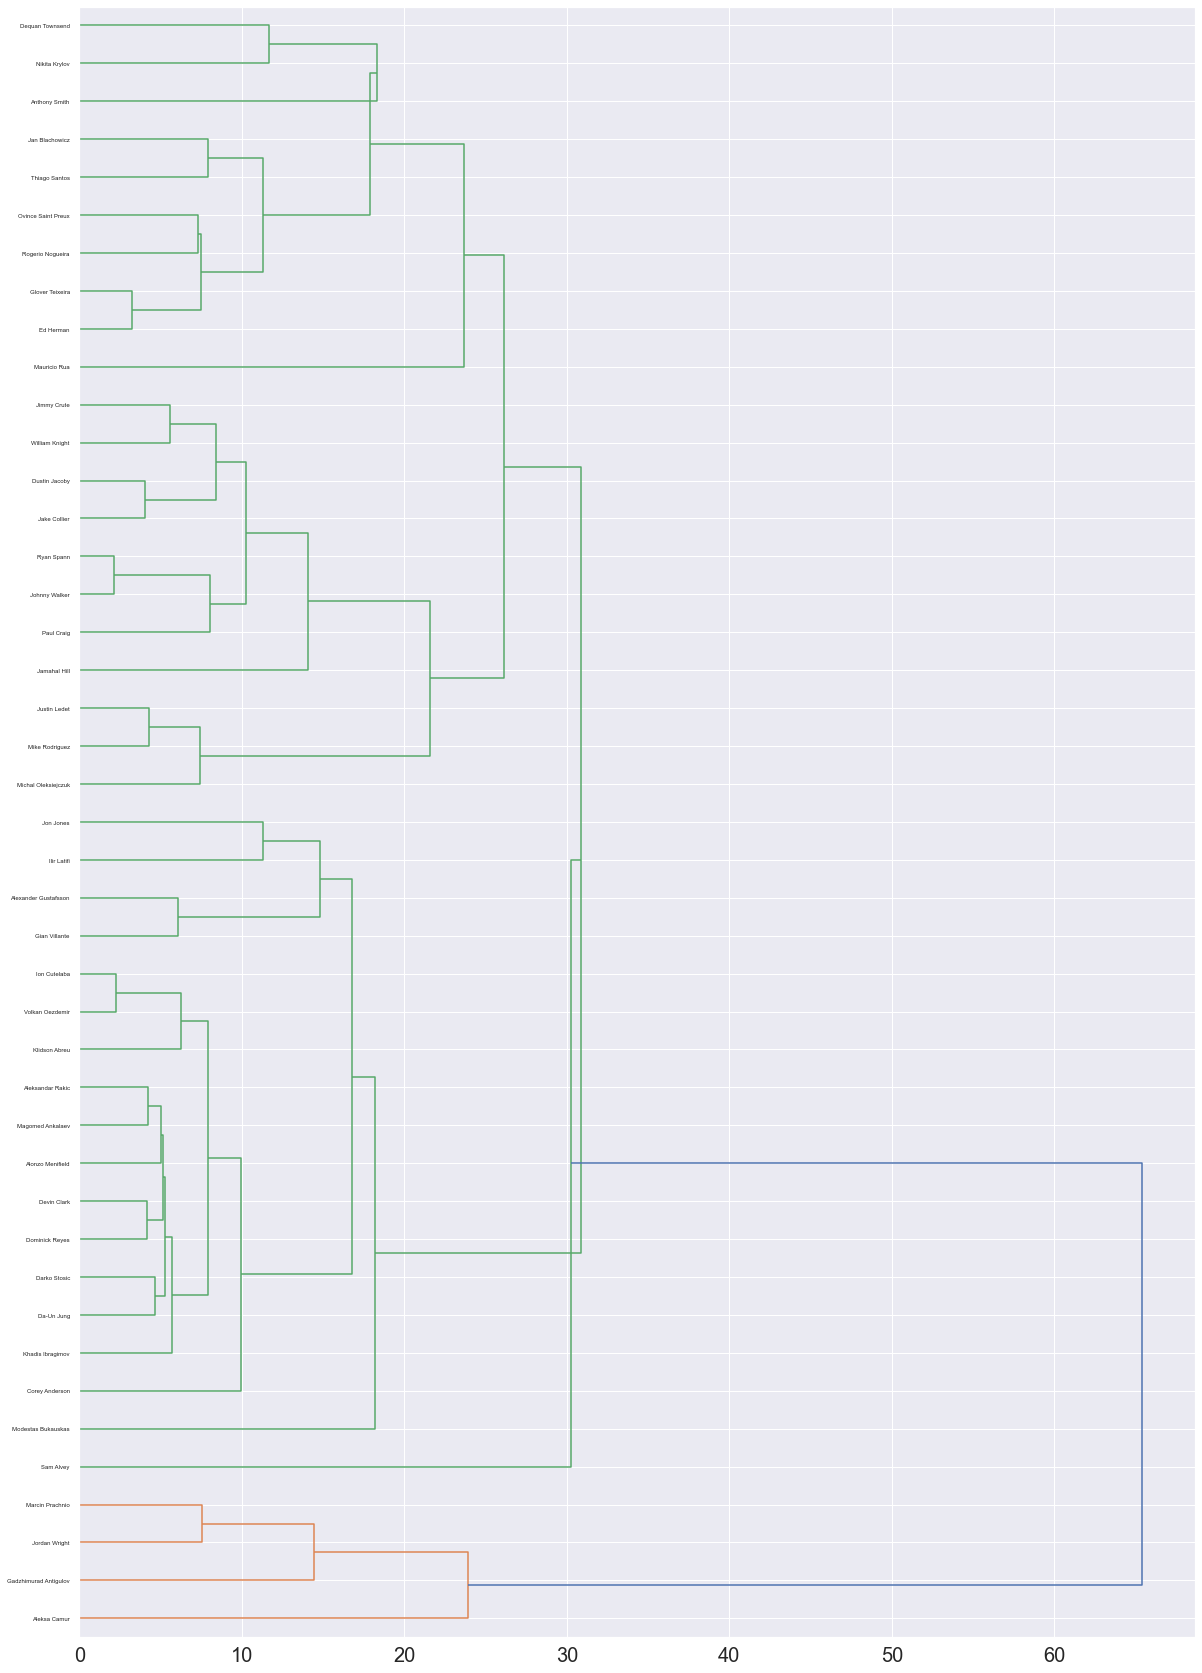

In [32]:
fig = plt.figure(figsize=(20, 30))
dn = dendrogram(Z, labels=df_modern['FighterName'].tolist(),
                orientation='right',
                leaf_rotation=0, leaf_font_size=6)
plt.savefig(join(figure_dir,'dendrogram_test.png'), dpi=dpi_save)

In [ ]:
# Select fights from 2012 and forward
df_modern = df[df.EventDate >= pd.Timestamp(2012,1,1)].copy()
# Ignore 5 round fights
df_modern = df_modern[df_modern.RoundFormat.str[0] == '3']
# Remove catch weight bouts, as they are not a standard weight class
df_modern = df_modern[df_modern.WeightClass != 'Catch Weight']

df_modern['Year'] = df_modern.loc[:,'EventDate'].dt.to_period('Y')
# Need to identify which outcomes count as finishes
method_map = {'Submission': True, 'KO/TKO': True, 'TKO - Doctor\'s Stoppage': True, 'DQ': True,
              'Could Not Continue': True, 'Decision - Split': False, 'Decision - Majority': False,
              'Decision - Unanimous': False, 'Overturned': False
             }
df_modern['Finish'] = df_modern.loc[:,'Method'].map(method_map)


# We want to include overturned fight outcomes, because a daily fantasy sports tournament will not
# be affected by a fight outcome that was overturned weeks later.
# Overturned bouts do not list the method of finish.
# However, a finish can be inferred from round and round time of the fight.
df_modern.loc[(df_modern.Method == 'Overturned') & \
              ~((df_modern.Round == 3) & (df_modern.RoundTime == '5:00')),'Finish'] = True

# Determine first fight on cards
# df_modern['TotalFights'] = df_modern.CardPosition.str.split(' of ').str[1].astype(int)
# df_modern['CardPosition'] = df_modern.CardPosition.str.split(' of ').str[0].astype(int)
# df_modern['FirstFight'] = df_modern['CardPosition'] == 1

# Order the weight classes by weight
cats =['Strawweight','Flyweight', 'Bantamweight',
       'Featherweight', 'Lightweight','Welterweight', 'Middleweight',
       'Light Heavyweight','Heavyweight']
df_modern['WeightClass'] = df_modern.WeightClass.astype('category')

df_modern['WeightClass'] = df_modern['WeightClass'].cat.reorder_categories(cats, ordered=True)


total_events = len(df_modern.EventName.unique())
date_today = date.today().strftime("%B %d, %Y")


print('From January 1, 2012 to {}, there have been {} UFC events.'.format(date_today, total_events))

What are indicators of skillset?

Grapplers should have more takedowns than strikers, maybe takedown defense
Wrestlers tend to secure position after a takedown, while BJJ'ers advance?
Are BJJ'ers more likely to reverse? More Subs/Sub attempts?

Can the clustering seperate well-rounded fighters from those who are one-trick ponies? Will champions be clustered?

In [ ]:
df_modern[''].head()

In [ ]:
overall_rates = df_modern.groupby(['FirstFight']).Finish.mean()
year_ff = (df_modern.groupby(['Year','FirstFight']).Finish.mean()*100)
ax = year_ff.unstack().plot(kind='barh',figsize=(16,9), color=['red','blue'])
_ = ax.set_title('UFC Finish Rate by Year: First Fight vs. All Others')
_ = ax.set_xlabel('Finish Rate (%)')
total_finish_rate_title = 'Finish Rate\n2012-2020'
total_finish_rate_true = '    {}%    '.format(round(overall_rates[True]*100,1))
total_finish_rate_false = '    {}%    '.format(round(overall_rates[False]*100,1))


x_box = 81
y_box = 2.
_ = ax.text(x_box, y_box, total_finish_rate_title, style='italic', color='black', fontsize=25,
        bbox={'facecolor': 'white', 'alpha': 0.85, 'pad': 10})
_ = ax.text(x_box, y_box - 0.75, total_finish_rate_true, style='italic', color='white', fontsize=25,
        bbox={'facecolor': 'blue', 'alpha': 0.85, 'pad': 10})
_ = ax.text(x_box, y_box - 1.5, total_finish_rate_false, style='italic', color='white', fontsize=25,
        bbox={'facecolor': 'red', 'alpha': 0.85, 'pad': 10})
_ = ax.set_xlim(right=100)

handles,labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[1]]
labels = [labels[1], labels[0]]
_ = ax.legend(handles,labels,title='First Fight\n  on Card')

plt.savefig(join(figure_dir,'Finish_Rate_First_Fight_vs_All_Others.png'), dpi=dpi_save)

We see 6 of the past 9 years have had higher finish rates in the first fight of the event than the rest of the fights. Furthermore, 3 of the last 4 years have this property. (It's interesting to note that both finish rates for 2019 are the lowest finishes rates from 2012-2020. Guess it wasn't a great year for fans.)

Let's see how the finish rates compare by weight class.

In [ ]:
wc_ff = df_modern.groupby(['WeightClass','FirstFight']).Finish.mean()*100
ax = wc_ff.unstack().plot(kind='barh',figsize=(16,9),color=['red','blue'])

first_fight_middle_rate = round(wc_ff.loc[('Middleweight',True)],1)
first_fight_middle_count = sum(df_modern[df_modern['FirstFight']]['WeightClass'] == 'Middleweight')

_ = ax.set_title('UFC Finish Rate by Weight Class (2012-2020)')

_ = ax.set_xlabel('Finish Rate (%)')
_ = ax.set_ylabel('Weight Class')
handles,labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[1]]
labels = [labels[1], labels[0]]
_ = ax.legend(handles,labels,title='First Fight\n  on Card')

plt.gcf().subplots_adjust(left=0.2)
plt.savefig(join(figure_dir,'Finish_Rate_by_Weight_Class.png'), dpi=dpi_save)

In [ ]:
print('Every weight class, with the exception of Featherweight (145 lbs.), has a higher finish rate \
for the first fight of the night!\nThe middleweight division has a finish rate of {}% when it\'s the \
first fight on the card!\nThe high finish rate of middleweights is calculated from {} fights.'.format(first_fight_middle_rate, first_fight_middle_count))

Notice that the finish rates for fights that are not the first on the card increase as the weight classes get heavier (115 lbs. at Strawweight up to a maximum weight of 265 lbs. at Heavyweight). This is to be expected, as heavier fighters tend to be more dangerous.

While we're at it, let's see if the COVID pandemic has affected the finish rate. March 14, 2020 (Pi Day!) was the last UFC fight before the schedule was severely disrupted.

In [ ]:
# POST-COVID
df_modern['PostCOVID'] = np.where(df_modern.EventDate > pd.Timestamp(2020,2,14), 'Post-COVID', 'Pre-COVID')

ax = (df_modern.groupby(['PostCOVID','FirstFight']).Finish.mean()*100).unstack().plot(kind='barh',figsize=(16,9),
                                                                            color=['red','blue'])
_ = ax.set_title('Effect of Pandemic on UFC Finish Rate')
_ = ax.set_xlabel('Finish Rate (%)')
_ = ax.set_ylabel('')
_ = ax.set_xlim(right=70)

handles,labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[1]]
labels = [labels[1], labels[0]]
_ = ax.legend(handles,labels,title='First Fight\n  on Card')

plt.savefig(join(figure_dir,'Effect_of_Pandemic_on_UFC_Finish_Rate.png'), dpi=dpi_save)

Seems the pandemic era of UFC as resulted in higher finish rates than previous years (still 2012-2020). The UFC initially had trouble getting fighters into the USA, which likely led to more fighters with less experience getting into the premier MMA organization. This trouble led to the creation of fight island in Abu Dhabi.

Certainly interesting, and needs further investigation, but let's get back to the hypothesis. Can the higher finish rate for the first fight be correlated to a mismatch of skill level? To investigate, we will look at the empirical cumulative distribution function (ECDF) of the total UFC fights of the fighters in the first fight at the time of their fight. If I've lost you at this stage, have no fear, I will interpret the results.

In [ ]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

def count_prev_fights(name, date):
    # search all events here for fighter's name and sum the fight experience they have prior to the considered bout.
    matches = df.apply(lambda row: ((row['FighterName1'] == name) | (row['FighterName2'] == name)), axis=1)
    return sum([(df.loc[i,'EventDate'] < date) for i, x in enumerate(matches) if x])

# This part will be very slow if we perform the operation for every fight.
# We only care about the first fights, so let's take what we need from the DataFrame
df_ff = df_modern[df_modern['FirstFight']].copy()
df_ff['PrevFights1'] = df_ff.apply(lambda row: count_prev_fights(row['FighterName1'],row['EventDate']), axis=1)
df_ff['PrevFights2'] = df_ff.apply(lambda row: count_prev_fights(row['FighterName2'],row['EventDate']), axis=1)
df_ff['PrevFightSum'] = df_ff['PrevFights2'] + df_ff['PrevFights1']

In [ ]:
df_finish = df_ff[df_ff['Finish']]['PrevFightSum']
df_no_finish = df_ff[~df_ff['Finish']]['PrevFightSum']
x_fin,y_fin = ecdf(df_finish)
x_no,y_no = ecdf(df_no_finish)
# data offset by 0.2 for visability
plt.scatter(x=x_no+0.2, y=y_no*100,label='No Finish',alpha=0.5,marker='d',color='red',s=100)
plt.scatter(x=x_fin, y=y_fin*100,label='Finish',alpha=0.5,marker='*',color='blue',s=100)
_ = plt.title('Empirical Cumultive Distribution Functions')
_ = plt.xlabel('Total UFC Fights Prior to Bout')
_ = plt.ylabel('% of Bouts with = or < Experience')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [500]
lgnd.legendHandles[1]._sizes = [500]

plt.savefig(join(figure_dir,'Empirical_Cumultive_Distribution_Functions.png'), dpi=dpi_save)

In [ ]:
# Determine the total number of fights with the greatest difference in ecdfs
greatest_diff = -1
total_fights = -1
for i in range(10):
    tot_fights = i
    diff_of_max = max(y_fin[x_fin<=tot_fights]) - max(y_no[x_no<=tot_fights])
    if diff_of_max > greatest_diff:
        greatest_diff = diff_of_max
        total_fights = i
print('Interpretation: Of the fights that were first on the card, {}% of matchups with a finish \
had a combined UFC fight history of 1 fight or less. (Fight history previous to fight considered.) \
For the fights that went to decision, {}% of matchups had a combined UFC fight history of 1 fight or less.\n\n\
We see the greatest difference in the ECDF for {} fights or less. {}% of matchups with a finish \
had a combined UFC fight history of {} fight or less.\
For the fights that went to decision, {}% of matchups had a combined UFC fight history of {} fight or less.\n\n'.format(
    round(max(y_fin[x_fin<=1])*100),
    round(max(y_no[x_no<=1])*100),
    total_fights,
    round(max(y_fin[x_fin<=total_fights])*100),
    total_fights,
    round(max(y_no[x_no<=total_fights])*100),
    total_fights))


These differences in ECDF are not as extreme as I had hoped, but they are present, nonetheless. We need to investigate further.

Before moving on, you may wonder why there are fighters with so much experience fighting in the first fight of the night. Generally, when there is a big main event fight, the UFC likes to stack the card. Or, an experienced fighter is on a losing streak. For example, UFC 249: Ferguson vs. Gaethje had 'Smiling' Sam Alvey fighting first. Alvey had 19 UFC fights entering that bout, but was on a 4-fight losing streak. (I hear Sam is still smiling, though.)

So, we've found some differences in the data based on whether or not the fight ended in a finish. The question remains: Is the observed difference statistically significant? Let's check the p-value. (Don't worry, I'll interpret.)

In [ ]:
# Null hypothesis significance testing
# Statistical significance?
def perm_fights(df_1,df_2,tot_fts):
    all_first_fights = np.concatenate((df_1,df_2))
    all_first_fights = np.random.permutation(all_first_fights)
    df_finish_perm_sample = all_first_fights[:len(df_1)]
    df_no_finish_perm_sample = all_first_fights[len(df_1):]
    x_fin,y_fin = ecdf(df_finish_perm_sample)
    x_no,y_no = ecdf(df_no_finish_perm_sample)
    return max(y_fin[x_fin<=tot_fts]) - max(y_no[x_no<=tot_fts])

test_count = 10**4
diff_of_max_perm_replicates = np.empty(test_count)
for i in range(test_count):
    diff_of_max_perm_replicates[i] = perm_fights(df_finish,df_no_finish,total_fights)

# _ = plt.hist(diff_of_max_perm_replicates,density=True,bins=25)
sns.histplot(diff_of_max_perm_replicates, stat='probability', bins=30, color='blue')
_ = plt.axvline(greatest_diff, color='red', linestyle='dashed', linewidth=3)
plt.title('Testing The Null Hypothesis')
plt.xlabel('Difference in ECDFs for 3 fights or less')

plt.savefig(join(figure_dir,'Testing_Null_Hypothesis.png'), dpi=dpi_save)

p = np.sum(diff_of_max_perm_replicates >= greatest_diff) / len(diff_of_max_perm_replicates)

In [ ]:
print('We get p-value = {}.'.format(p))

For a p-value to be statistically significant, it needs to be less than 0.05. Therefore, the analysis does not back up the hypothesis that the first fight on the card is more likely to have a finish due to a mismatch in skill level.

If you've made it this far into the analysis, you may wonder why I bothered to highlight my failed hypothesis. It is important to come to terms with a failed hypothesis. While I was an undergraduate at the University at Buffalo, a graduate student in physics gave me an anecdote that has resonated throughout the years: Earning a PhD only takes about 5 days of good research, the rest of your time will be spent dealing with your failures. Perhaps a slight exaggeration, it's still a great reminder that there is always something to learn from your mistaken hypotheses. I leave you with a quote from Sir Anthony Hopkins' character in West World:

> "Mistakes" is the word you're too embarrassed to use. You ought not to be. You're a product of a trillion of them. Evolution forged the entirety of sentient life on this planet using only one tool: the mistake.

Let me know if you have questions, comments, or criticisms. (Especially criticism, as I aim to learn more.)